# DDPG W/ AI GYM HOPPER

https://gymnasium.farama.org/environments/mujoco/hopper/

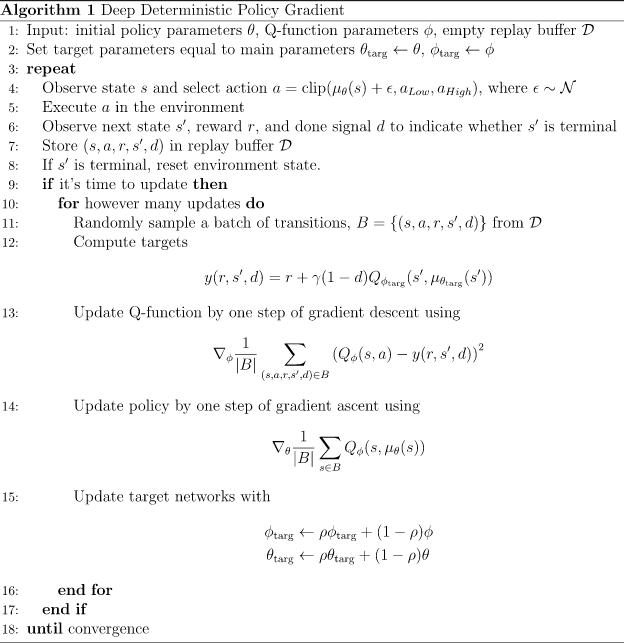


https://spinningup.openai.com/en/latest/algorithms/ddpg.html

spinning up benchmarks


In [1]:
%%sh
echo "y" | pip uninstall mujoco-py


In [2]:
import numpy as np
import gymnasium as gym
from collections import deque
import random

# Ornstein-Ulhenbeck Process
# Taken from #https://github.com/vitchyr/rlkit/blob/master/rlkit/exploration_strategies/ou_strategy.py
class OUNoise(object):
    def __init__(self, action_space, mu=0.0, theta=0.05, max_sigma=0.2, min_sigma=0.001, decay_period=100000):
        self.mu           = mu
        self.theta        = theta
        self.sigma        = max_sigma
        self.max_sigma    = max_sigma
        self.min_sigma    = min_sigma
        self.decay_period = decay_period
        self.action_dim   = action_space.shape[0]
        self.low          = action_space.low
        self.high         = action_space.high
        self.reset()
        
    def reset(self):
        self.state = np.ones(self.action_dim) * self.mu
        
    def evolve_state(self):
        x  = self.state
        dx = self.theta * (self.mu - x) + self.sigma * np.random.randn(self.action_dim)
        self.state = x + dx
        return self.state
    
    def get_action(self, action, t=0):
        ou_state = self.evolve_state()
        self.sigma = self.max_sigma - (self.max_sigma - self.min_sigma) * min(1.0, t / self.decay_period)
        return np.clip(action + ou_state, self.low, self.high)       

class Memory:
    def __init__(self, max_size):
        self.max_size = max_size
        self.buffer = deque(maxlen=max_size)
    
    def push(self, state, action, reward, next_state, done):
        experience = (state, action, np.array([reward]), next_state, done)
        self.buffer.append(experience)

    def sample(self, batch_size):
        state_batch = []
        action_batch = []
        reward_batch = []
        next_state_batch = []
        done_batch = []

        batch = random.sample(self.buffer, batch_size)

        for experience in batch:
            state, action, reward, next_state, done = experience
            state_batch.append(state)
            action_batch.append(action)
            reward_batch.append(reward)
            next_state_batch.append(next_state)
            done_batch.append(done)
        
        return state_batch, action_batch, reward_batch, next_state_batch, done_batch

    def __len__(self):
        return len(self.buffer)

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F 
import torch.autograd
from torch.autograd import Variable

class Critic(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        
        super(Critic, self).__init__()
        self.linear1 = nn.Linear(input_size  + output_size, hidden_size)
        self.linear2 = nn.Linear(hidden_size, hidden_size)
        self.linear3 = nn.Linear(hidden_size, output_size)

    def forward(self, state, action):
        """
        Params state and actions are torch tensors        
        """
        x = torch.cat([state, action], 1)
        x = F.relu(self.linear1(x))         
        x = F.relu(self.linear2(x))
        x = self.linear3(x)

        return x

class Actor(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, learning_rate = 3e-4):
        super(Actor, self).__init__()
        self.linear1 = nn.Linear(input_size, hidden_size)
        self.linear2 = nn.Linear(hidden_size, hidden_size)
        self.linear3 = nn.Linear(hidden_size, output_size)
        
    def forward(self, state):
        """
        Param state is a torch tensor
        """
        x = F.relu(self.linear1(state))
        x = F.relu(self.linear2(x))
        x = torch.tanh(self.linear3(x))

        return x

# if gpu is to be used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [4]:
import torch
import torch.autograd
import torch.optim as optim
import torch.nn as nn


class DDPGagent:
    def __init__(self, 
                 env, 
                 hidden_size=256, 
                 actor_learning_rate=1e-4, 
                 critic_learning_rate=1e-3, 
                 gamma=0.99, 
                 tau=1e-3, 
                 max_memory_size=1000000,
                 device = None):
        # Params
        self.num_states = env.observation_space.shape[0]
        self.num_actions = env.action_space.shape[0]    
        self.gamma = gamma
        self.tau = tau
        
        if device is not None:
            self.device = device
        else:
            self.device = 'cpu'

        # Networks
        self.actor = Actor(self.num_states, hidden_size, self.num_actions).to(self.device)
        self.actor_target = Actor(self.num_states, hidden_size, self.num_actions).to(self.device)
        self.critic = Critic(self.num_states, hidden_size, self.num_actions).to(self.device)
        self.critic_target = Critic(self.num_states, hidden_size, self.num_actions).to(self.device)
        
        #copy params
        for target_param, param in zip(self.actor_target.parameters(), self.actor.parameters()):
            target_param.data.copy_(param.data)

        for target_param, param in zip(self.critic_target.parameters(), self.critic.parameters()):
            target_param.data.copy_(param.data)
        
        # Training
        self.memory = Memory(max_memory_size)        
        self.critic_criterion  = nn.MSELoss()
        self.actor_optimizer  = optim.Adam(self.actor.parameters(), lr=actor_learning_rate)
        self.critic_optimizer = optim.Adam(self.critic.parameters(), lr=critic_learning_rate)
    
    def get_action(self, state):
        state = Variable(torch.from_numpy(state).float().unsqueeze(0))
        action = self.actor.forward(state)
        action = action.detach().numpy()[0,0]
        return action
    
    def update(self, batch_size):
        states, actions, rewards, next_states, dones = self.memory.sample(batch_size)
        states = torch.FloatTensor(np.array(states)).to(self.device)
        actions = torch.FloatTensor(np.array(actions)).to(self.device)
        rewards = torch.FloatTensor(np.array(rewards)).to(self.device)
        next_states = torch.FloatTensor(np.array(next_states)).to(self.device)
        dones = torch.FloatTensor(np.array(dones)).to(self.device)
    
        # Critic loss  
        # get Qvals
        Qvals = self.critic.forward(states, actions)
        #get next actions from actor
        next_actions = self.actor_target.forward(next_states)
        #get next action values from critic target
        next_Q = self.critic_target.forward(next_states, next_actions.detach())
        #calculate q prime (used in critic loss)
        Qprime = rewards + self.gamma * (1-dones).unsqueeze(1) * next_Q
        #calc loss btw Qvals and Qprime
        critic_loss = self.critic_criterion(Qvals, Qprime)

        # Actor loss
        policy_loss = -self.critic.forward(states, self.actor.forward(states)).mean()
        
        #update critic
        self.critic_optimizer.zero_grad(set_to_none = True)        
        critic_loss.backward() 
        torch.nn.utils.clip_grad_norm_(self.critic.parameters(), 15)  
        self.critic_optimizer.step()        

        # Actor loss
        policy_loss = -self.critic.forward(states, self.actor.forward(states)).mean()
        
        # update actor
        self.actor_optimizer.zero_grad(set_to_none = True)
        policy_loss.backward()
        torch.nn.utils.clip_grad_norm_(self.actor.parameters(), 15)
        self.actor_optimizer.step()


        # soft update target networks 
        for target_param, param in zip(self.actor_target.parameters(), self.actor.parameters()):
            target_param.data.copy_(param.data * self.tau + target_param.data * (1.0 - self.tau))
       
        for target_param, param in zip(self.critic_target.parameters(), self.critic.parameters()):
            target_param.data.copy_(param.data * self.tau + target_param.data * (1.0 - self.tau))
            

episode: 0, reward: 7.89, last 10 ep average reward: 7.89, total steps: 12
episode: 20, reward: 9.03, last 10 ep average reward: 5.96, total steps: 301
episode: 40, reward: 1.94, last 10 ep average reward: 3.29, total steps: 716
episode: 60, reward: 7.51, last 10 ep average reward: 5.39, total steps: 1049
episode: 80, reward: 83.79, last 10 ep average reward: 22.55, total steps: 1307
episode: 100, reward: 57.21, last 10 ep average reward: 37.69, total steps: 1960
episode: 120, reward: 28.98, last 10 ep average reward: 54.05, total steps: 2613
episode: 140, reward: 48.33, last 10 ep average reward: 49.83, total steps: 3191
episode: 160, reward: 65.43, last 10 ep average reward: 60.29, total steps: 3825
episode: 180, reward: 48.1, last 10 ep average reward: 46.93, total steps: 4505
episode: 200, reward: 40.43, last 10 ep average reward: 47.99, total steps: 5123
episode: 220, reward: 59.63, last 10 ep average reward: 61.76, total steps: 5744
episode: 240, reward: 72.84, last 10 ep average

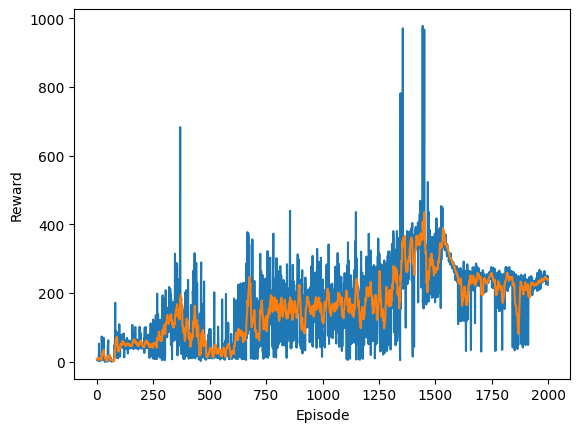

In [5]:
import sys
import gymnasium as gym
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

env = gym.make('Hopper-v4')

agent = DDPGagent(env)
noise = OUNoise(env.action_space)
batch_size = 256
rewards = []
avg_rewards = []
total_steps = 0
noise.reset()

for episode in range(2000):
    state = env.reset()[0]    
    episode_reward = 0
    
    for step in range(1000):
        

        action = agent.get_action(state)
        action = noise.get_action(action, total_steps)
        new_state, reward, done, trunc, _ = env.step(action) 
        agent.memory.push(state, action, reward, new_state, done)
        
        if len(agent.memory) > (batch_size * 4):
            agent.update(batch_size)        
        
        state = new_state
        episode_reward += reward
        
        total_steps += 1

        if done or step>=999:
            rewards.append(episode_reward)
            avg_rewards.append(np.mean(rewards[-10:]))
            
            if episode%20 == 0:
                print("episode: {}, reward: {}, last 10 ep average reward: {}, total steps: {}".format(episode, 
                                                                            np.round(episode_reward, decimals=2),
                                                                            np.round(np.mean(rewards[-10:]), decimals = 2),
                                                                            total_steps))
            break    

plt.plot(rewards)
plt.plot(avg_rewards)
plt.plot()
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.show()
